<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Mehdi Abbaszadeh

**Student ID**: 99106403


# ****Support Vector Machines****

In this notebook, you will implement SVM for three datasets. You will become more familiar with the Soft-Margin SVM and the Kernel trick, which makes SVM extremely powerful.

Before we start our implementation, you must be comfortable with the theoretical details of the Soft-Margin SVM as an optimization problem and be able to derive the dual formulation for this problem. In the next sections, you will solve the dual optimization problem for all datasets using the CVXPY library, which has been developed for solving convex optimization problems. To get more familiar with CVXPY programming, you can use this [link](https://www.cvxpy.org).

This is the primal formulation for the Soft-Margin SVM for linearly separable data with slack variables $\xi_i \ge 0$:

\begin{equation*}
\begin{aligned}
& {\text{min.}}
& & \frac{1}{2} \|w\|^2 + C \sum_{i=1}^{N} \xi_i \\
& \text{s.t.}
& & y_i(w^T x_i + b) \geq 1 - \xi_i, \; i = 1, \ldots, N \\
& & & \xi_i \geq 0, \; i = 1, \ldots, N
\end{aligned}
\end{equation*}

Where $w$ represents the weight vector, $b$ is the bias term, and $C$ is the regularization parameter controlling the trade-off between a wide margin and misclassification.

**Theoretical Questions:**

1) Derive the dual optimization problem for the Soft-Margin SVM.

2) How do we calculate the weights and bias ($w$ and $b$) using the dual problem optimum points?

3) How do we classify new data points using the optimal weights and bias?

<font color='green'>Write down your answers as markdown here.</font>

Sometimes, the data is not linearly separable. Therefore, the previous formulation of the Soft-Margin SVM does not give a good accuracy for the classification problem. The Kernel trick is a technique used in such situations. Consider $x$ as your input features with dimension $p$. One can use function $\phi: R^p → R^d$ to map the input features to another space with dimension $d$. Finding good $\phi$ such that data points become near linearly separable makes the previous formulation of the problem and its dual useful by replacing $\phi(x_i)$ for $x_i$ in the problem definition. The function $\phi(x)$ can even be a mapping to an infinite-dimensional space.

If you have found the correct dual form of the Soft-Margin SVM in the previous formulation, you can see that the terms $x_i^T x_j$ will appear in the problem formulation and the prediction rule. These terms will be replaced with $\phi(x_i)^T \phi(x_j)$ when we use $\phi$ as our feature mapping function. Given a feature mapping $\phi$ we define its corresponding **Kernel** to be:

\begin{equation*}
\begin{aligned}
& K(x, z) = \phi(x)^T \phi(z)
\end{aligned}
\end{equation*}

Hence, in the dual optimization problem and the prediction rule of the Soft-Margin SVM, we can replace all terms in the form $x^T z$ with $K(x, z)$. This technique is called the Kernel trick.

Now, given $\phi$, we could easily compute $K(x,z)$ by finding $\phi(x)$ and $\phi(z)$ and taking their inner product. But what’s more interesting is that often, $K(x,z)$ may be very inexpensive to calculate, even though $\phi(x)$ itself may be very expensive to calculate (perhaps because it is an extremely high-dimensional vector). Check Stanford's CS229 [notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) on SVM and the Kernel trick for more details and examples.

## Libraries

Here are some useful libraries for the implementation. You can add or remove any libraries as you wish. Note that you cannot use sklearn or similar libraries for implementation.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import cvxpy as cp

## **Dataset Exploration**

In this notebook, you'll be working with three datasets, specifically named "DF1.csv", "DF2.csv", and "DF3.csv". Each dataset entry is composed of a 2-dimensional feature vector and a label, which is either "1" or "-1". The primary objective of this notebook is to leverage SVM to develop a robust classifier for each dataset.

You are given three kernels as follows:



1.   Linear Kernel: $K(x, z) = x^T z$
2.   Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$, where $p$ is the dimension of the feature space.
3.   RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$

Before implementing, you must choose the correct kernel for each dataset. Note that each kernel must be used exactly for one dataset. Therefore, you cannot use one of the kernels twice. As a part of our grading scheme, what matters with respect to accuracy is the sum of the accuracies you reach for all three datasets, and the accuracy of each model does not have any separate score. Thus, it would help if you chose the most appropriate kernel for each dataset so that all datasets reach a reasonably good accuracy.





Load all datasets and show the first 5 rows of each.

In [3]:
## YOUR CODE HERE

df1 = pd.read_csv('DF1.csv')
df2 = pd.read_csv('DF2.csv')
df3 = pd.read_csv('DF3.csv')

print("First 5 rows of DF1:")
print(df1.head())

print("\nFirst 5 rows of DF2:")
print(df2.head())

print("\nFirst 5 rows of DF3:")
print(df3.head())

First 5 rows of DF1:
         x1        x2  y
0  6.462652  5.121478 -1
1 -6.586541 -7.721287  1
2  9.239683 -8.595738 -1
3  4.250052  2.143755  1
4  8.219779 -3.609733 -1

First 5 rows of DF2:
         x1         x2  y
0  2.937145  77.102291  1
1 -0.029344  44.802353  1
2  5.868818  44.595757 -1
3  8.609281  49.223945 -1
4  7.763276 -14.340750 -1

First 5 rows of DF3:
         x1        x2  y
0 -0.517768 -0.466158 -1
1  0.940985  0.235175  1
2 -0.470720  0.917120  1
3  0.712716 -0.097401 -1
4 -0.608773 -0.107034 -1


Use the following function to visualize the datapoints for all datasets.


Visualizing DF1:


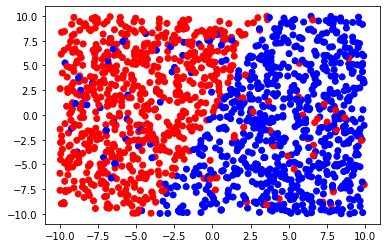


Visualizing DF2:


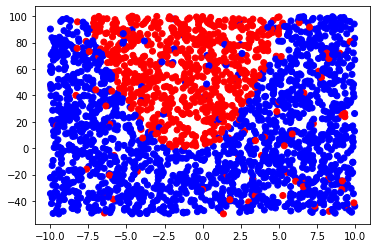


Visualizing DF3:


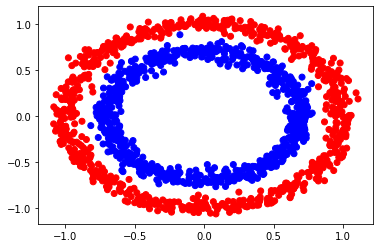

In [5]:
def visualize_data(X, y):
  col = []
  for i in range(len(y)):
    if y[i] == 1:
      col.append('red')
    else:
      col.append('blue')
  plt.scatter(X[ : , 0], X[ : , 1], color = col)
  plt.show()

## YOUR CODE HERE
# Visualize each dataset
print("\nVisualizing DF1:")
visualize_data(df1.iloc[:, :-1].values, df1['y'].values)

print("\nVisualizing DF2:")
visualize_data(df2.iloc[:, :-1].values, df2['y'].values)

print("\nVisualizing DF3:")
visualize_data(df3.iloc[:, :-1].values, df3['y'].values)

**Theoretical Question:**

Which kernel will you use for each dataset? Justify your answer

Note: your implementation must follow your choice here. Otherwise, you do not recieve any points for your implemetation.

<font color='green'>Write down your answers as markdown here.</font>
i use Linear Kernel: $K(x, z) = x^T z$ for dataset 1. because as i see in the first image above, this dataset is linearly
separable. 

i use Polynomial Kernel of degree 2: $K(x, z) = (1 + ∑_{i = 1}^{p} x_i z_i)^2$ for dataset 2. because as i see in the second image above, datas of one of the groups are shaped like a second order polynomial. so kernel 2 is suitable for this data set.
separable.

i use RBF Kernel: $K(x, z) = e^{-\frac{||x-z||_2^2}{2σ^2}}$ for dataset 3. because as i see in the third image above, this dataset is like a two circle such as the kernel (because of the term($|x-z||_2^2$)). so kernel 3 is suitable for this dataset.

## Dataset one (DF1.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [17]:
## YOUR CODE HERE
def get_features_and_labels(df):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# Extract features and labels for DF1
X1, y1 = get_features_and_labels(df1)

# Split DF1 into train and test sets (20% test, random state 42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [18]:
## YOUR CODE HERE

y1_train = y1_train.astype(np.double)

n_samples = X1_train_scaled.shape[0]

# dual problem variable
alpha = cp.Variable(n_samples)

# define kernel1 (linear kernel)
K = np.dot(X1_train_scaled, X1_train_scaled.T)
K_psd = cp.psd_wrap(K)

# dual objective
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y1_train, alpha), K_psd))

# constraints
constraints = [alpha >= 0, alpha <= 1, cp.sum(cp.multiply(y1_train, alpha)) == 0]

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# optimal values of alpha
alpha_values = alpha.value

print("Optimized alpha values:", alpha_values)

# Support vectors have non-zero Lagrange multipliers (alpha values)
support_vectors = np.where(alpha_values > 1e-4)[0]

# Extract support vectors
X_sv = X1_train_scaled[support_vectors]
y_sv = y1_train[support_vectors]
alpha_sv = alpha_values[support_vectors]

# Compute the weight vector
w = np.sum((alpha_sv * y_sv)[:, None] * X_sv, axis=0)

# Compute the bias term
b = np.mean(y_sv - np.dot(X_sv, w))

# Print the weight vector and bias term
print("Weight vector:", w)
print("Bias term:", b)

Optimized alpha values: [ 1.00000000e+00  1.11525575e-18 -1.12152865e-19 ...  1.00000000e+00
  1.06646969e-18  1.23276150e-18]
Weight vector: [-2.11074894  0.57371719]
Bias term: -0.16219172823842284


Predict the class of each entry in the test set using your learned model.

In [19]:
## YOUR CODE HERE
decision_function = np.dot(X1_test_scaled, w) + b

# Predict class labels based on the sign of the decision function
y1_pred = np.sign(decision_function)

# Ensure the predicted class labels are in the original format (e.g., -1 and 1)
y1_pred = np.where(y1_pred >= 0, 1, -1)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [20]:
## YOUR CODE HERE
report = classification_report(y1_test, y1_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.92      0.93      0.92       148
           1       0.93      0.92      0.92       148

    accuracy                           0.92       296
   macro avg       0.92      0.92      0.92       296
weighted avg       0.92      0.92      0.92       296



## Dataset two (DF2.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [21]:
## YOUR CODE HERE
## YOUR CODE HERE
def get_features_and_labels(df):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# Extract features and labels for DF2
X2, y2 = get_features_and_labels(df2)

# Split DF1 into train and test sets (20% test, random state 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [26]:
## YOUR CODE HERE
import warnings
warnings.filterwarnings("ignore")


y2_train = y2_train.astype(np.double)

n_samples = X2_train_scaled.shape[0]

# dual problem variable
alpha = cp.Variable(n_samples)

# define the kernel function
def polynomial_kernel(X):
    return (1 + np.dot(X, X.T)) ** 2

K = polynomial_kernel(X2_train_scaled)
K_psd = cp.psd_wrap(K)

# dual objective
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y2_train, alpha), K_psd))

# constraints
constraints = [alpha >= 0, alpha <= 1, cp.sum(cp.multiply(y2_train, alpha)) == 0]

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# optimal values of alpha
alpha_values = alpha.value

print("Optimized alpha values:", alpha_values)

# Support vectors have non-zero Lagrange multipliers (alpha values)
support_vectors = np.where(alpha_values > 1e-4)[0]

# Extract support vectors
X_sv = X2_train_scaled[support_vectors]
y_sv = y2_train[support_vectors]
alpha_sv = alpha_values[support_vectors]

# compute the bias (for prediction for non linear kernel, we use dual form directly (in the next cell) )
K_sv = polynomial_kernel(X_sv)
b = np.mean(y_sv - np.sum(alpha_sv * y_sv[:, None] * K_sv, axis=0))

Optimized alpha values: [-1.68694327e-05  1.00000481e+00 -2.33588342e-05 ... -1.09171348e-04
 -3.40666114e-05 -1.43193847e-05]


Predict the class of each entry in the test set using your learned model.

In [23]:
## YOUR CODE HERE
# Define a function to compute the decision function for the polynomial kernel
def decision_function_poly(X):
    K_test = (1 + np.dot(X, X_sv.T)) ** 2
    return np.sum(alpha_sv * y_sv * K_test, axis=1) + b

# Compute the decision function for the test set
decision_function = decision_function_poly(X2_test_scaled)

# Predict class labels based on the sign of the decision function
y2_pred = np.sign(decision_function)

# Ensure the predicted class labels are in the original format (e.g., -1 and 1)
y2_pred = np.where(y2_pred >= 0, 1, -1)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [24]:
## YOUR CODE HERE
report = classification_report(y2_test, y2_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.89      0.99      0.94       336
           1       0.97      0.74      0.84       160

    accuracy                           0.91       496
   macro avg       0.93      0.86      0.89       496
weighted avg       0.91      0.91      0.90       496



## Dataset three (DF3.csv)

Split the dataset into train and test sets (20 percent for test). Use 42 as the random state and do not forget to scale the data.

In [27]:
## YOUR CODE HERE
def get_features_and_labels(df):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    return X, y

# Extract features and labels for DF3
X3, y3 = get_features_and_labels(df3)

# Split DF1 into train and test sets (20% test, random state 42)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X3_train_scaled = scaler.fit_transform(X3_train)
X3_test_scaled = scaler.transform(X3_test)

Use CVXPY to solve the dual problem with the appropriate kernel using the training set.

In [30]:
## YOUR CODE HERE

y3_train = y3_train.astype(np.double)

n_samples = X3_train_scaled.shape[0]

# dual problem variable
alpha = cp.Variable(n_samples)

# define the kernel function
def rbf_kernel(X, Z, gamma):
    sq_dists = -2 * np.dot(X, Z.T) + np.sum(X**2, axis=1)[:, None] + np.sum(Z**2, axis=1)[None, :]
    return np.exp(-gamma * sq_dists)


# Set the value of gamma (1/(2*sigma^2))
gamma = 0.5  # You can adjust this value based on your dataset
K = rbf_kernel(X3_train_scaled, X3_train_scaled, gamma)
K_psd = cp.psd_wrap(K)

# dual objective
objective = cp.Maximize(cp.sum(alpha) - 0.5 * cp.quad_form(cp.multiply(y3_train, alpha), K_psd))

# constraints
constraints = [alpha >= 0, alpha <= 1, cp.sum(cp.multiply(y3_train, alpha)) == 0]

# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# optimal values of alpha
alpha_values = alpha.value

print("Optimized alpha values:", alpha_values)

# Support vectors have non-zero Lagrange multipliers (alpha values)
support_vectors = np.where(alpha_values > 1e-4)[0]

# Extract support vectors
X_sv = X3_train_scaled[support_vectors]
y_sv = y3_train[support_vectors]
alpha_sv = alpha_values[support_vectors]

# compute the bias (for prediction for non linear kernel, we use dual form directly (in the next cell) )
K_sv = rbf_kernel(X_sv, X_sv, gamma)
b = np.mean(y_sv - np.sum(alpha_sv * y_sv[:, None] * K_sv, axis=0))

Optimized alpha values: [ 1.71630301e-19 -4.25000320e-18  4.57867657e-18 ...  4.30189189e-18
 -1.83236560e-18  1.00000000e+00]


Predict the class of each entry in the test set using your learned model.

In [31]:
## YOUR CODE HERE
def decision_function_rbf(X):
    K_test = rbf_kernel(X, X_sv, gamma)
    return np.sum(alpha_sv * y_sv * K_test, axis=1) + b

# Compute the decision function for the test set
decision_function = decision_function_rbf(X3_test_scaled)

# Predict class labels based on the sign of the decision function
y3_pred = np.sign(decision_function)

# Ensure the predicted class labels are in the original format (e.g., -1 and 1)
y3_pred = np.where(y3_pred >= 0, 1, -1)

Use classification_report function (from sklearn) to get the accuracy of your model.

In [32]:
## YOUR CODE HERE
report = classification_report(y3_test, y3_pred)
print(report)

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00       152
           1       0.99      1.00      1.00       140

    accuracy                           1.00       292
   macro avg       1.00      1.00      1.00       292
weighted avg       1.00      1.00      1.00       292

